In [2]:
import sklearn
import pandas as pd
#from fbprophet import Prophet

In [3]:
#cdf = pd.read_csv('/Volumes/Curt-MacPro-Backup/D3M/terra/processing/V2/s4_height_s1.csv')
cdf = pd.read_csv('/media/clisle/Backup Plus/terra/processing/V2/s4_height_s1.csv')


In [4]:
train_df = cdf[['genotype_id','day_number','range','column']]
target_df = cdf['height(cm)']

In [5]:
X_train = train_df.values
y_train = target_df.values
print(X_train.shape)
print(y_train.shape)

(38877, 4)
(38877,)


In [6]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LinearRegression
from sklearn import svm
from sklearn.ensemble import GradientBoostingRegressor

tree = DecisionTreeRegressor(max_depth=4).fit(X_train, y_train)
linear_reg = LinearRegression().fit(X_train, y_train)
#svm_mod = svm.SVR().fit(X_train, y_train)
gbr_mod = GradientBoostingRegressor(n_estimators=100, learning_rate=0.1, max_depth=1, random_state=0, loss='ls').fit(X_train, y_train)

pred_tree = tree.predict(X_train)
pred_lr = linear_reg.predict(X_train)
#pred_svm = svm_mod.predict(X_train)
pred_gbr = gbr_mod.predict(X_train)


In [7]:
cdf['decision_tree'] = pred_tree
cdf['linearRegression'] = pred_lr
#cdf['svm'] = pred_svm
cdf['gboost'] = pred_gbr
cdf.head()

,Unnamed: 0,day_number,range,column,sensor,height(cm),genotype_id,genotype_string,decision_tree,linearRegression,gboost
0,0,118,3,2,1,5.89,1,PI329465,6.0141,-16.214895,-3.746922
1,2,121,3,2,1,6.15,1,PI329465,6.0141,-7.025053,-3.746922
2,4,123,3,2,1,5.98,1,PI329465,6.0141,-0.898492,-3.746922
3,6,124,3,2,1,5.99,1,PI329465,6.0141,2.164789,-3.746922
4,8,125,3,2,1,6.02,1,PI329465,6.0141,5.228070,-3.746922


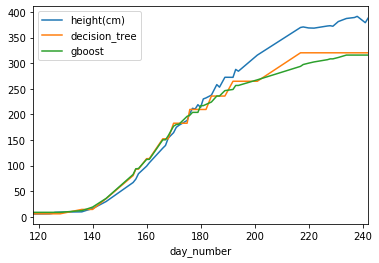

In [8]:
%matplotlib inline
import matplotlib.pyplot as plt

def plot_cultivar(fulldf,cultivar):
    df = fulldf.loc[fulldf['genotype_id'] == cultivar]
    minCol = df['column'].min()
    df = df.loc[df['column']==minCol]
    #print(df.shape)
    df = df[['day_number','height(cm)','decision_tree','gboost']]
    df = df.set_index('day_number')
    df.plot()

#plot_cultivar(cdf,'PI145619')
plot_cultivar(cdf,5)

In [9]:
#note, try StandardScalar on the training data

Now try training a MLP on the dataset to see if this can better fit the data

In [10]:
from keras import models
from keras import layers

Using TensorFlow backend.
/home/clisle/anaconda3/envs/tf_gpu/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/clisle/anaconda3/envs/tf_gpu/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/clisle/anaconda3/envs/tf_gpu/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/clisle/anacond

In [11]:

def build_model(train_data):

    # start with an empty model
    model = models.Sequential()
    
    # add a first layer with 64 neurons/outputs
    model.add(layers.Dense(64, activation='relu',
                           input_shape=(train_data.shape[1],)))
    
    # add a second layer, also with 64 nodes/outputs
    model.add(layers.Dense(16, activation='relu'))
    
    # add a final layer without any activation function!  
    # Just let the floating point value come out directly without being adjusted
    model.add(layers.Dense(1))
    
    # standard compile options for a regression problem
    model.compile(optimizer='rmsprop', loss='mse', metrics=['mae'])
    
    # return the model so it can be trained
    return model

In [13]:
model = build_model(X_train)
print('training model')
model.fit(X_train,y_train,epochs=10, batch_size=1, verbose=2)
print('evaluating model fit:')
val_mse, val_mae = model.evaluate(X_train, y_train, verbose=0)
print(val_mse,val_mae)





training model


Epoch 1/10
 - 144s - loss: 4339.3961 - mean_absolute_error: 53.3474
Epoch 2/10
 - 132s - loss: 2084.4475 - mean_absolute_error: 36.3199
Epoch 3/10
 - 120s - loss: 1504.2189 - mean_absolute_error: 30.6235
Epoch 4/10
 - 120s - loss: 1364.9545 - mean_absolute_error: 28.9948
Epoch 5/10
 - 120s - loss: 1219.4361 - mean_absolute_error: 26.7323
Epoch 6/10
 - 119s - loss: 1150.7439 - mean_absolute_error: 25.4128
Epoch 7/10
 - 120s - loss: 1112.1107 - mean_absolute_error: 24.8333
Epoch 8/10
 - 120s - loss: 1060.3685 - mean_absolute_error: 24.1857
Epoch 9/10
 - 120s - loss: 1032.0120 - mean_absolute_error: 23.7386
Epoch 10/10
 - 120s - loss: 1029.7204 - mean_absolute_error: 23.6955
evaluating model fit:
961.6001449825557 22.902077291821133


In [14]:
# add the MLP predictions as another column in the dataframe
cdf['mlp'] = model.predict(X_train)

In [15]:
cdf.head()

,Unnamed: 0,day_number,range,column,sensor,height(cm),genotype_id,genotype_string,decision_tree,linearRegression,gboost,mlp
0,0,118,3,2,1,5.89,1,PI329465,6.0141,-16.214895,-3.746922,-16.562172
1,2,121,3,2,1,6.15,1,PI329465,6.0141,-7.025053,-3.746922,-14.254258
2,4,123,3,2,1,5.98,1,PI329465,6.0141,-0.898492,-3.746922,-12.736730
3,6,124,3,2,1,5.99,1,PI329465,6.0141,2.164789,-3.746922,-11.984815
4,8,125,3,2,1,6.02,1,PI329465,6.0141,5.228070,-3.746922,-11.232923


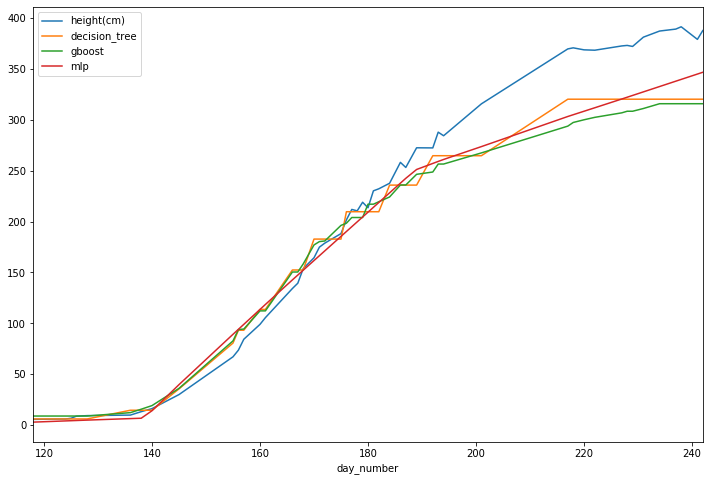

In [21]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (12,8)

def plot_cultivar(fulldf,cultivar):
    df = fulldf.loc[fulldf['genotype_id'] == cultivar]
    minCol = df['column'].min()
    df = df.loc[df['column']==minCol]
    #print(df.shape)
    df = df[['day_number','height(cm)','decision_tree','gboost','mlp']]
    df = df.set_index('day_number')
    df.plot()

#plot_cultivar(cdf,'PI145619')
plot_cultivar(cdf,5)

In [24]:
cdf.to_csv("/media/clisle/Backup Plus/terra/processing/V2/s4_with_predictions.csv")

So the models don't fit well when a single model tries to fit ALL the different cultivars.  We need to break up the field and fit a model per cultivar.  Lets select a single cultivar and test fit several models. 

In [13]:
single = cdf.loc[cdf['genotype_id'] == 5]
single[0:10]

,Unnamed: 0,day_number,range,column,sensor,height(cm),genotype_id,genotype_string,decision_tree,linearRegression,gboost
423,788,118,3,6,1,5.59,5,PI330181,6.01410,-11.181033,8.869446
424,790,121,3,6,1,5.78,5,PI330181,6.01410,-1.991191,8.869446
425,792,123,3,6,1,5.90,5,PI330181,6.01410,4.135370,8.869446
426,794,124,3,6,1,5.94,5,PI330181,6.01410,7.198651,8.869446
427,796,125,3,6,1,6.67,5,PI330181,6.01410,10.261932,8.869446
428,798,126,3,6,1,8.74,5,PI330181,6.01410,13.325212,8.869446
429,800,128,3,6,1,9.28,5,PI330181,6.01410,19.451774,8.869446
430,802,136,3,6,1,9.81,5,PI330181,14.55964,43.958019,12.215789
431,804,138,3,6,1,13.16,5,PI330181,14.55964,50.084581,15.579196
432,806,140,3,6,1,16.16,5,PI330181,14.55964,56.211142,19.139754


In [14]:
def returnUniqueCounts(dframe):
    return pd.DataFrame.from_records([(col, dframe[col].nunique()) for col in dframe.columns],
                          columns=['Column_Name', 'Num_Unique']).sort_values(by=['Num_Unique'])

In [15]:
returnUniqueCounts(single)

,Column_Name,Num_Unique
4,sensor,1
6,genotype_id,1
7,genotype_string,1
2,range,2
3,column,2
8,decision_tree,13
1,day_number,69
10,gboost,70
0,Unnamed: 0,115
5,height(cm),115


In [16]:
s_train_df = single[['genotype_id','day_number','range','column']]
s_target_df = single['height(cm)']

In [17]:
X_train = s_train_df.values
y_train = s_target_df.values
print(X_train.shape)
print(y_train.shape)

(115, 4)
(115,)


In [18]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LinearRegression
from sklearn import svm
from sklearn.ensemble import GradientBoostingRegressor

tree = DecisionTreeRegressor(max_depth=4).fit(X_train, y_train)
linear_reg = LinearRegression().fit(X_train, y_train)
#svm_mod = svm.SVR().fit(X_train, y_train)
gbr_mod = GradientBoostingRegressor(n_estimators=100, learning_rate=0.1, max_depth=1, random_state=0, loss='ls').fit(X_train, y_train)

pred_tree = tree.predict(X_train)
pred_lr = linear_reg.predict(X_train)
#pred_svm = svm_mod.predict(X_train)
pred_gbr = gbr_mod.predict(X_train)


In [19]:
s4_single = single
s4_single['decision_tree'] = pred_tree
s4_single['linearRegression'] = pred_lr
s4_single['gboost'] = pred_gbr
s4_single.head()

/home/clisle/anaconda3/envs/tf_gpu/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/home/clisle/anaconda3/envs/tf_gpu/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/home/clisle/anaconda3/envs/tf_gpu/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice fro

,Unnamed: 0,day_number,range,column,sensor,height(cm),genotype_id,genotype_string,decision_tree,linearRegression,gboost
423,788,118,3,6,1,5.59,5,PI330181,7.035,-31.356193,-2.635891
424,790,121,3,6,1,5.78,5,PI330181,7.035,-20.017512,-2.635891
425,792,123,3,6,1,5.90,5,PI330181,7.035,-12.458392,-1.970353
426,794,124,3,6,1,5.94,5,PI330181,7.035,-8.678832,-0.529951
427,796,125,3,6,1,6.67,5,PI330181,7.035,-4.899272,-0.529951


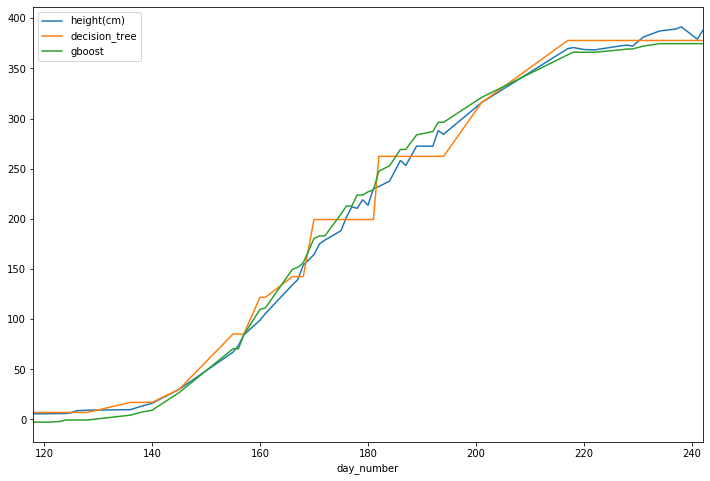

In [20]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (12,8)

def plot_cultivar(fulldf,cultivar):
    df = fulldf.loc[fulldf['genotype_id'] == cultivar]
    minCol = df['column'].min()
    df = df.loc[df['column']==minCol]
    #print(df.shape)
    df = df[['day_number','height(cm)','decision_tree','gboost']]
    df = df.set_index('day_number')
    df.plot()

plot_cultivar(s4_single,5)

In [36]:
s4_single.to_csv("/media/clisle/Backup Plus/terra/processing/V2/s4_cultivar5_with_predictions.csv")

The above plot is really simpler than the data.  The plot corresponds to a single column, which means either one or two plants (since they are planted side by side.) The plot automatically selected the minimum column to render. However, the models are being fitted with all plants (generally 2 or 4 instances) 4 in the case of genotype_id=5.  So they have to take into account multiple heights per grid location.  I should really isolate a single plan and run the models to try and fit it.  Here goes...

In [21]:
truly_single = single.loc[(single['range']==3) & (single['column']==6)]

In [22]:
print(single.shape)
print(truly_single.shape)

(115, 11)
(51, 11)


In [23]:
ts_sorted = truly_single.set_index('day_number')

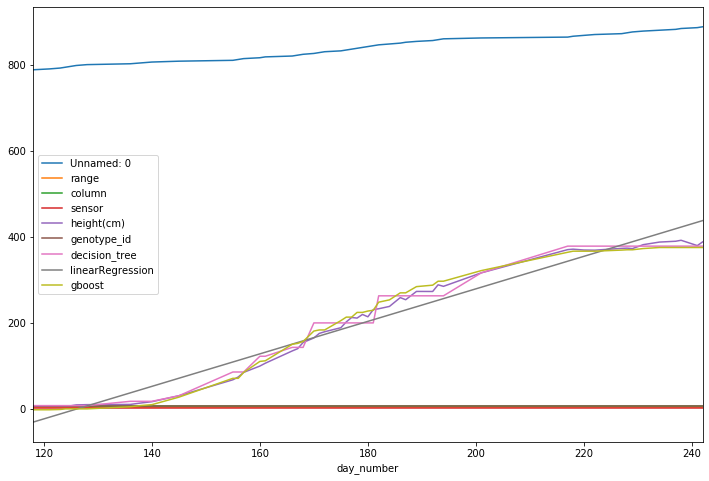

In [24]:
ts_sorted.plot()

OK, above is a plot of truly a single plant (in the height column), but the models need to be run, because they were fitted to 4 plants.  

ts = truly single

In [25]:
ts_train_df = truly_single[['day_number']]
ts_target_df = truly_single['height(cm)']
X_train = ts_train_df.values
y_train = ts_target_df.values
print(X_train.shape)
print(y_train.shape)

(51, 1)
(51,)


In [28]:

tree = DecisionTreeRegressor(max_depth=4).fit(X_train, y_train)
linear_reg = LinearRegression().fit(X_train, y_train)
svm_mod = svm.SVR().fit(X_train, y_train)
gbr_mod = GradientBoostingRegressor(n_estimators=100, learning_rate=0.1, max_depth=1, random_state=0, loss='ls').fit(X_train, y_train)

pred_tree = tree.predict(X_train)
pred_lr = linear_reg.predict(X_train)
pred_svm = svm_mod.predict(X_train)
pred_gbr = gbr_mod.predict(X_train)

s4_truly_single = truly_single
s4_truly_single['decision_tree'] = pred_tree
s4_truly_single['linearRegression'] = pred_lr
s4_truly_single['svm'] = pred_svm
s4_truly_single['gboost'] = pred_gbr
s4_truly_single.head()


/home/clisle/anaconda3/envs/tf_gpu/lib/python3.7/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/home/clisle/anaconda3/envs/tf_gpu/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
/home/clisle/anaconda3/envs/tf_gpu/lib/python3.7/site-packages/ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentatio

,Unnamed: 0,day_number,range,column,sensor,height(cm),genotype_id,genotype_string,decision_tree,linearRegression,gboost,svm
423,788,118,3,6,1,5.59,5,PI330181,8.703,-26.152747,7.172083,211.189815
424,790,121,3,6,1,5.78,5,PI330181,8.703,-15.067046,7.172083,211.171376
425,792,123,3,6,1,5.90,5,PI330181,8.703,-7.676579,7.172083,210.785304
426,794,124,3,6,1,5.94,5,PI330181,8.703,-3.981346,7.172083,210.435740
427,796,125,3,6,1,6.67,5,PI330181,8.703,-0.286112,7.172083,210.435740


In [29]:
from keras import models
from keras import layers

model = build_model(X_train)
print('training model')
model.fit(X_train,y_train,epochs=10, batch_size=1, verbose=2)
print('evaluating model fit:')
val_mse, val_mae = model.evaluate(X_train, y_train, verbose=0)
print(val_mse,val_mae)

training model
Epoch 1/10
 - 0s - loss: 26626.3944 - mean_absolute_error: 135.7944
Epoch 2/10
 - 0s - loss: 12399.1016 - mean_absolute_error: 96.1688
Epoch 3/10
 - 0s - loss: 9378.2646 - mean_absolute_error: 83.8181
Epoch 4/10
 - 0s - loss: 9247.3507 - mean_absolute_error: 82.7912
Epoch 5/10
 - 0s - loss: 9159.7100 - mean_absolute_error: 81.5869
Epoch 6/10
 - 0s - loss: 9133.8827 - mean_absolute_error: 81.0265
Epoch 7/10
 - 0s - loss: 9200.4773 - mean_absolute_error: 82.2760
Epoch 8/10
 - 0s - loss: 9113.7706 - mean_absolute_error: 82.3658
Epoch 9/10
 - 0s - loss: 9190.2676 - mean_absolute_error: 82.5694
Epoch 10/10
 - 0s - loss: 9170.0762 - mean_absolute_error: 81.5670
evaluating model fit:
8885.986203661152 80.89319446040135


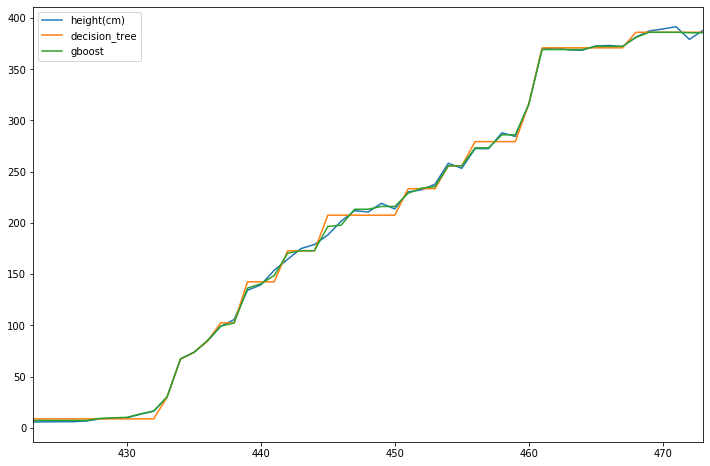

In [30]:
ts_plot = s4_truly_single[['height(cm)','decision_tree','gboost']]
ts_plot.plot()

In [31]:
s4_truly_single['mlp'] = model.predict(X_train)
s4_truly_single.head()

/home/clisle/anaconda3/envs/tf_gpu/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


,Unnamed: 0,day_number,range,column,sensor,height(cm),genotype_id,genotype_string,decision_tree,linearRegression,gboost,svm,mlp
423,788,118,3,6,1,5.59,5,PI330181,8.703,-26.152747,7.172083,211.189815,142.243332
424,790,121,3,6,1,5.78,5,PI330181,8.703,-15.067046,7.172083,211.171376,145.861298
425,792,123,3,6,1,5.90,5,PI330181,8.703,-7.676579,7.172083,210.785304,148.273224
426,794,124,3,6,1,5.94,5,PI330181,8.703,-3.981346,7.172083,210.435740,149.479202
427,796,125,3,6,1,6.67,5,PI330181,8.703,-0.286112,7.172083,210.435740,150.685181


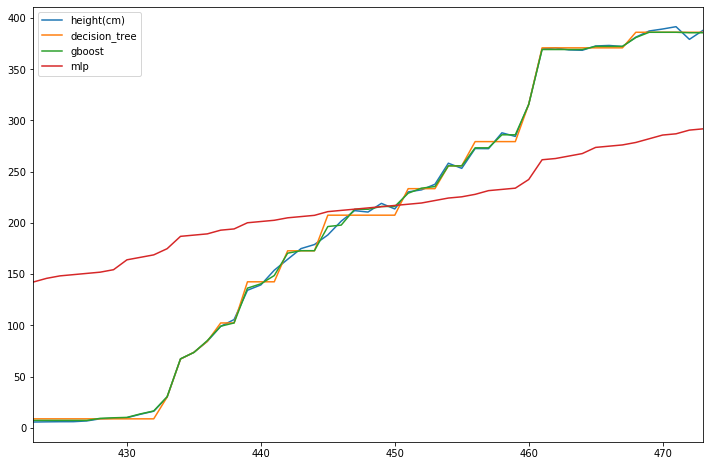

In [36]:
ts_plot = s4_truly_single[['height(cm)','decision_tree','gboost','mlp']]
ts_plot.plot()

In [33]:
ts_plot.to_csv('s4_cult5_r3c6__fitted_models.csv')